# Quantum Control as Polynomial Optimization: Synthesizing unitary target

This notebook uses multithreading 

    julia --threads=number of avalible threads


In [113]:
Threads.nthreads()

1

In [114]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials, MomentTools
using TSSOS
using QuadGK
using MosekTools
using JuMP
using Random
using NLopt

## Quantum system

In [115]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V ./= norm(V, Inf);

In [116]:
H0

3×3 Matrix{Float64}:
 0.0  0.0       0.0
 0.0  0.515916  0.0
 0.0  0.0       1.0

In [117]:
V

3×3 Matrix{Float64}:
 0.0       0.707107  0.0
 0.707107  0.0       1.0
 0.0       1.0       0.0

## Utilities for working with Polynomials

In [118]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

square_frobenius_norm (generic function with 1 method)

## Get the truncated Magnus expansion ($n=3$)

In [119]:
@polyvar x[1:3]
@polyvar t[1:3]

# final time
T = 0.1

function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function A(t, x)
    #=
    The generator of motion entering the Magnus expansion
    =#
    (H0 + V * u(t, x)) / im
end

function commutator(a, b)
    a * b - b * a
end 

# get the partial sum of the Magnus expansion
A₁ = A(t[1], x)
A₂ = A(t[2], x)

Ω = ∫(A₁, t[1], 0, T)

# 2nd term in the Magnus expansion
Ω .+= 1//2 * ∫(∫(
    commutator(A₁, A₂), 
    t[2], 0, t[1]), 
    t[1], 0, T
)

# 3nd term in the Magnus expansion

A₃ = A(t[3], x)

Ω .+= 1//6 * ∫(∫(∫(
    commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
    t[3], 0, t[2]),
    t[2], 0, t[1]),
    t[1], 0, T
);

## Construct the polynomial $\tanh_p \frac{\Omega^{(n)}}{2}$ with $n=p=3$

In [120]:
Ω = convert(typeof(A₁), Ω)

Ω²¼ = Ω^2 / 4

tanh₃ = (Ω/2) * (I + Ω²¼ * (-1//3 * I + 2//15 * Ω²¼));

## Getting statistic for checking the performance of quantum control formulation as a polynomial optimization

In [121]:
function get_unitray(x::AbstractArray)
    #=
    Get the unitary given the coefficients for the polynomial control
    =#
    basis = NLevelBasis(size(H0)[1])

    𝓗₀ = DenseOperator(basis, basis, H0)
    𝓥 = DenseOperator(basis, basis, V)

    H = LazySum([1., u(0, x)], [𝓗₀, 𝓥])
        
    function 𝓗(t, psi)
        H.factors[2] = u(t, x)
        return H
    end

    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)
    
    return Matrix(𝓤[2].data)
end


function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

In [122]:
n_samples = 1 #1000
Random.seed!(6292022)

# randomly generate the coefficients for the polynomial control 
exact_x = -1 .+ 2 * rand(length(x) * n_samples)
exact_x = reshape(exact_x, (length(x), n_samples))

# The values of objective functions for exact x
obj_exact_x = zeros(n_samples)

# the estimate of the global minimum of the polynomial objective function using MomentTools
glob_obj_min = zeros(n_samples)

# the polynomial objective at min_x
glob_obj_min_x = zeros(n_samples)

# The global minimum via TSSOS library
tssos_glob_obj_min = zeros(n_samples)

# Frobenius norm difference between target and obtained unitaries
norm_U_target_minus_obtained = zeros(n_samples)

# Frobenius norm difference between target and the truncated Magnus expansion
norm_U_target_minus_expΩ_exact_x = zeros(n_samples)
norm_U_target_minus_expΩ_min_x = zeros(n_samples)

# Convergence test for the Magnus expansion for the exact control (convergence_test_exact_x < 1)
convergence_test_exact_x = zeros(n_samples)

# Convergence test for the Magnus expansion for the obtained control (convergence_test_min_x < 1)
convergence_test_min_x = zeros(n_samples)

Threads.@threads for i=1:n_samples
    # target unitray
    U_target = get_unitray(exact_x[:, i])
    
    # get the polynomial objective function
    obj = square_frobenius_norm(
        I - U_target + (I + U_target) * tanh₃
    )
    
    # save the value of objective function for exact x
    obj_exact_x[i] = obj(exact_x[:, i])
  
    # Perform polynomial optimization using MomentTools
    optimizer = optimizer_with_attributes(Mosek.Optimizer, "QUIET" => true)
    glob_obj_min[i], M = minimize(obj, [], [], variables(obj), maxdegree(obj) ÷ 2, optimizer)
    
    # Extract the estimate for the global minimum 
    r = get_minimizers(M)
    obj_min_vals = [obj(r[:, j]) for j=1:size(r)[2]]
    min_x = r[:, argmin(obj_min_vals)]

    # refine the estimate by local minimization
    min_x = local_minimize(obj, min_x)
    
    # the polynomial objective at min_x
    glob_obj_min_x[i] = obj(min_x)
    
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true)
    
    previous_opt = opt
    
    while ~isnothing(opt)
        previous_opt = opt

        opt,sol,data = tssos_higher!(data; QUIET = true)
    end
    
    tssos_glob_obj_min[i] = previous_opt
        
    # get the Frobenius norm difference between target and obtained unitaries
    norm_U_target_minus_obtained[i] = norm(U_target - get_unitray(min_x))
    
    # check the accuracy of the Magnus expansion
    Ω_exact_x = convert(Matrix{ComplexF64}, subs(Ω, x=>exact_x[:, i]))
    norm_U_target_minus_expΩ_exact_x[i] = norm(U_target - exp(Ω_exact_x))

    Ω_min_x = convert(Matrix{ComplexF64}, subs(Ω, x=>min_x))
    norm_U_target_minus_expΩ_min_x[i] = norm(U_target - exp(Ω_min_x))
    
    # Convergence test for the Magnus expansion for the exact control
    convergence_test_exact_x[i] = quadgk(t -> opnorm(A(t, exact_x[:, i])), 0, T)[1] / π

    # Convergence test for the Magnus expansion for the obtained control
    convergence_test_min_x[i] = quadgk(t -> opnorm(A(t, min_x)), 0, T)[1] / π    
end

************************TSSOS************************
TSSOS is launching...
optimum = 8.289603146759245e-9
No higher TSSOS hierarchy!


## Saving results

In [46]:
using HDF5

h5open("results.hdf5", "w") do fid
    fid["exact_x"] = exact_x
    fid["obj_exact_x"] = obj_exact_x
    fid["glob_obj_min"] = glob_obj_min
    fid["tssos_glob_obj_min"] = tssos_glob_obj_min
    fid["norm_U_target_minus_obtained"] = norm_U_target_minus_obtained
    fid["convergence_test_exact_x"] = convergence_test_exact_x
    fid["convergence_test_min_x"] = convergence_test_min_x
end;

## Analysis

In [74]:
using Plots
using LaTeXStrings

### Benchmarking TSSOS vs MomentTools libraires

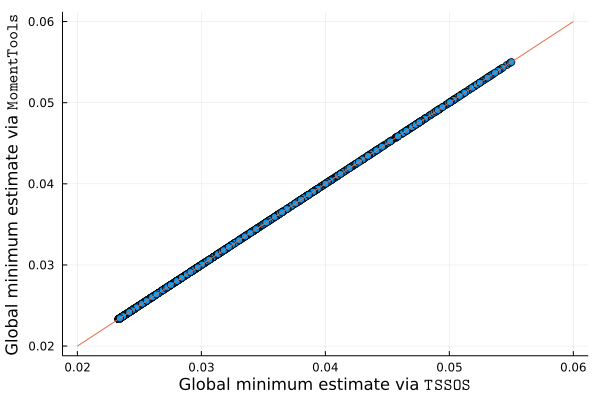

In [120]:
scatter(tssos_glob_obj_min, glob_obj_min, label=nothing)
plot!([0.02, 0.06], [0.02, 0.06], label=nothing)
xlabel!("Global minimum estimate via " * L"\texttt{TSSOS}")
ylabel!("Global minimum estimate via " * L"\texttt{MomentTools}")
#savefig("Fig_TSSOSvsMomentTools.pdf")

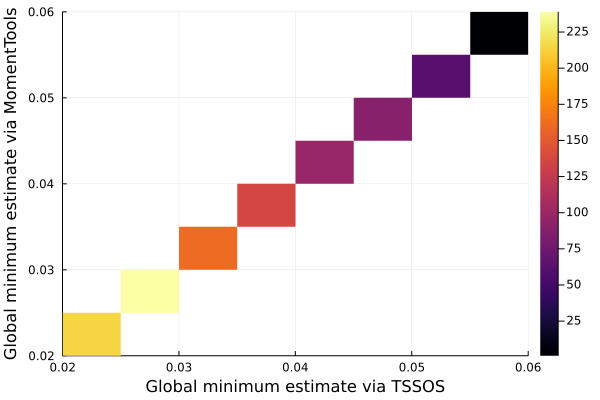

In [55]:
histogram2d(tssos_glob_obj_min, glob_obj_min, label=nothing)
xlabel!("Global minimum estimate via TSSOS")
ylabel!("Global minimum estimate via MomentTools")

### Actual global minimum vs global minimum estimate via MomentTools

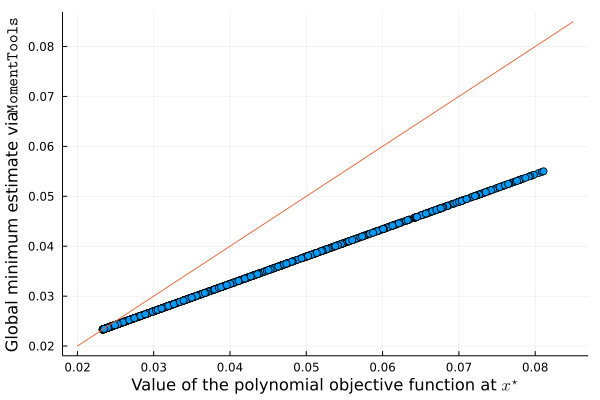

In [131]:
scatter(obj_exact_x, glob_obj_min, label=nothing)
plot!([0.02, 0.085], [0.02, 0.085], label=nothing)
xlabel!("Value of the polynomial objective function at " * L"x^{\star}")
ylabel!("Global minimum estimate via" * L"\texttt{MomentTools}")
#savefig("Fig_MomentToolsvsXstar.pdf")

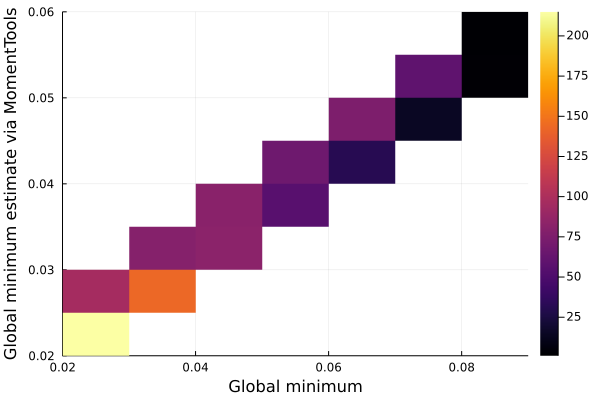

In [58]:
histogram2d(obj_exact_x, glob_obj_min)
xlabel!("Global minimum")
ylabel!("Global minimum estimate via MomentTools")

### Obtained unitray $\hat{U}$ vs the target $U^{\star}$

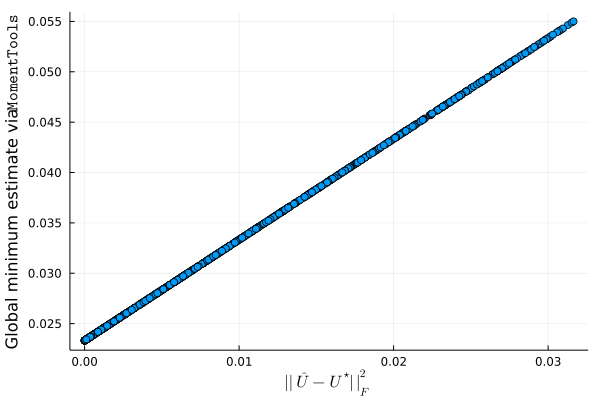

In [143]:
scatter(norm_U_target_minus_obtained .^ 2, glob_obj_min, label=nothing)
xlabel!(L"\|\| \widehat{U} - U^{\star} \|\|_F^2")
ylabel!("Global minimum estimate via" * L"\texttt{MomentTools}")
#savefig("Fig_PolynomialOptVsCoherenControl.pdf")

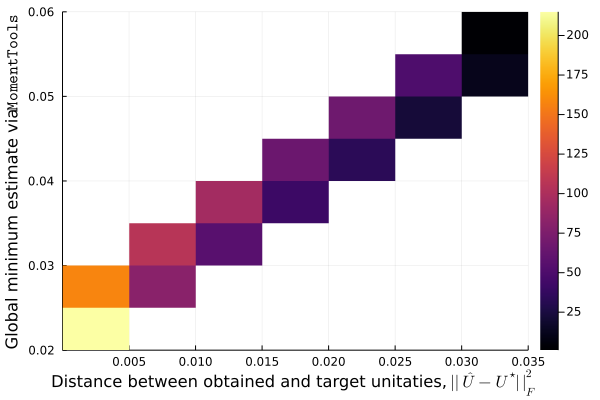

In [127]:
histogram2d(norm_U_target_minus_obtained .^ 2, glob_obj_min)
xlabel!("Distance between obtained and target unitaties, " * L"\|\| \widehat{U} - U^{\star} \|\|_F^2")
ylabel!("Global minimum estimate via" * L"\texttt{MomentTools}")

### Convergence tests

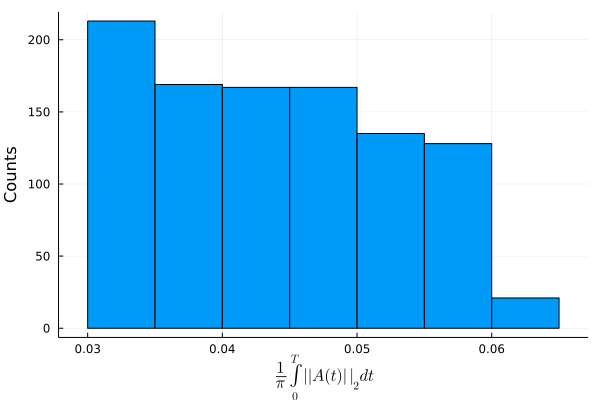

In [137]:
histogram(convergence_test_exact_x, label=nothing)
xlabel!(L"\frac{1}{\pi} \int_0^T || A(t) ||_2 dt")
ylabel!("Counts")
# savefig("Fig_ConvergenceTestXstar.pdf")

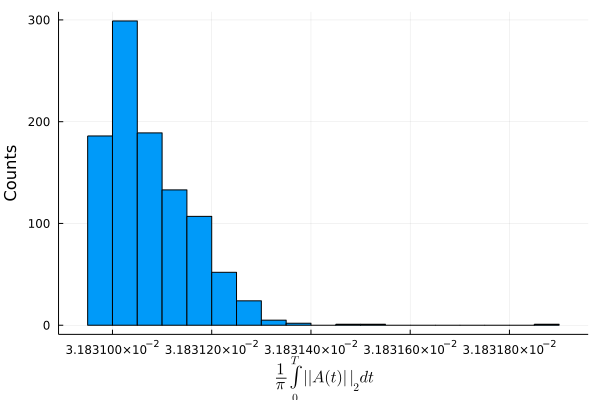

In [141]:
histogram(convergence_test_min_x, label=nothing)
xlabel!(L"\frac{1}{\pi} \int_0^T || A(t) ||_2 dt")
ylabel!("Counts")
#savefig("Fig_ConvergenceTestXHat.pdf")